In [5]:
# import bibliotek
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
# wczytanie pliku
df = pd.read_csv("household_power_consumption.txt", sep = ";", low_memory=False)

In [7]:
# wyświetlenie informacji o df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [8]:
# wyświetlenie pierwszych 10 rzędów
df.head(10)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
5,16/12/2006,17:29:00,3.520,0.522,235.020,15.000,0.000,2.000,17.0
6,16/12/2006,17:30:00,3.702,0.520,235.090,15.800,0.000,1.000,17.0
7,16/12/2006,17:31:00,3.700,0.520,235.220,15.800,0.000,1.000,17.0
8,16/12/2006,17:32:00,3.668,0.510,233.990,15.800,0.000,1.000,17.0
9,16/12/2006,17:33:00,3.662,0.510,233.860,15.800,0.000,2.000,16.0


In [9]:
# zmiana nazw kolumn
df.columns = ["Date", "Time", "Active_power", "Reactive_power", 
              "Voltage", "Intensity", "Kitchen", "Laundry", "Heater"]

In [10]:
# weryfikacja istnienia duplikatów
df.duplicated().any()

False

In [11]:
# połączenie Date i Time w jedną kolumnę oraz ich usunięcie
df["Date_time"] = pd.to_datetime(df["Date"] + df["Time"], format="%d/%m/%Y%H:%M:%S")
df = df.drop(columns=["Date", "Time"])

In [12]:
# usunięcie danych z 2006 roku
df.drop(df.head(21996).index,inplace=True)
df = df.reset_index(drop=True)

In [13]:
# usunięcie danych z listopada 2010 roku
df.drop(df.tail(37263).index,inplace=True)

In [14]:
# weryfikacja, że nulle to niecałe 1.5% df
df[df.isna().any(axis=1)]

,Active_power,Reactive_power,Voltage,Intensity,Kitchen,Laundry,Heater,Date_time
19836,?,?,?,?,?,?,NaN,2007-01-14 18:36:00
39913,?,?,?,?,?,?,NaN,2007-01-28 17:13:00
76258,?,?,?,?,?,?,NaN,2007-02-22 22:58:00
76259,?,?,?,?,?,?,NaN,2007-02-22 22:59:00
120592,?,?,?,?,?,?,NaN,2007-03-25 17:52:00
...,...,...,...,...,...,...,...,...
1968189,?,?,?,?,?,?,NaN,2010-09-28 19:09:00
1968190,?,?,?,?,?,?,NaN,2010-09-28 19:10:00
1968191,?,?,?,?,?,?,NaN,2010-09-28 19:11:00
1968192,?,?,?,?,?,?,NaN,2010-09-28 19:12:00


In [15]:
# usuniecie nulli
df = df.dropna().reset_index(drop=True)

In [16]:
# zmiana na floaty
df[["Active_power", "Reactive_power", "Voltage", "Intensity", 
    "Kitchen", "Laundry"]] = df[["Active_power", "Reactive_power", 
                                 "Voltage", "Intensity", "Kitchen", 
                                 "Laundry"]].apply(pd.to_numeric)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990025 entries, 0 to 1990024
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Active_power    float64       
 1   Reactive_power  float64       
 2   Voltage         float64       
 3   Intensity       float64       
 4   Kitchen         float64       
 5   Laundry         float64       
 6   Heater          float64       
 7   Date_time       datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 121.5 MB


In [19]:
# zamiana Watów na Kilowaty
df["Kitchen"] = df["Kitchen"].div(1000)
df["Laundry"] = df["Laundry"].div(1000)
df["Heater"] = df["Heater"].div(1000)

In [20]:
# zamiana minut na godziny
df = df.resample("D", on="Date_time").agg({"Active_power": "sum", 
                                           "Reactive_power": "sum",
                                           "Voltage": "mean",
                                           "Intensity": "mean",
                                           "Kitchen": "sum",
                                           "Laundry": "sum",
                                           "Heater": "sum"}).reset_index()

In [27]:
df["Voltage"].replace(to_replace=np.nan,value=df["Voltage"].median(), inplace=True)

In [28]:
df["Intensity"].replace(to_replace=np.nan,value=df["Intensity"].median(), inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date_time       1400 non-null   datetime64[ns]
 1   Active_power    1400 non-null   float64       
 2   Reactive_power  1400 non-null   float64       
 3   Voltage         1400 non-null   float64       
 4   Intensity       1400 non-null   float64       
 5   Kitchen         1400 non-null   float64       
 6   Laundry         1400 non-null   float64       
 7   Heater          1400 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 87.6 KB


In [30]:
#dodanie sumy energii łącznej
Sum_of_energy = df["Kitchen"]+df["Laundry"]+df["Heater"]
df["Sum_of_energy"] = Sum_of_energy

In [31]:
Kitchen_percentage = df["Kitchen"]/df["Sum_of_energy"]
df["Kitchen_percentage"]=Kitchen_percentage

In [32]:
Laundry_percentage = df["Laundry"]/df["Sum_of_energy"]
df["Laundry_percentage"]=Laundry_percentage

In [33]:
Heater_percentage = df["Heater"]/df["Sum_of_energy"]
df["Heater_percentage"] = Heater_percentage

In [34]:
df

,Date_time,Active_power,Reactive_power,Voltage,Intensity,Kitchen,Laundry,Heater,Sum_of_energy,Kitchen_percentage,Laundry_percentage,Heater_percentage
0,2007-01-01,2749.004,148.166,240.128979,7.916944,0.000000,0.000352,0.005880,0.006232,0.000000,0.056483,0.943517
1,2007-01-02,1269.236,190.342,241.943778,3.714028,0.000000,0.000348,0.006562,0.006910,0.000000,0.050362,0.949638
2,2007-01-03,1014.054,196.728,243.557090,3.014028,0.000000,0.000344,0.004765,0.005109,0.000000,0.067332,0.932668
3,2007-01-04,3259.412,202.302,239.750299,9.478194,0.001051,0.007597,0.010896,0.019544,0.053776,0.388713,0.557511
4,2007-01-05,2713.364,173.154,240.495764,7.885139,0.001483,0.000379,0.007602,0.009464,0.156699,0.040046,0.803254
...,...,...,...,...,...,...,...,...,...,...,...,...
1395,2010-10-27,1260.278,153.832,246.108708,3.622917,0.000000,0.002058,0.008269,0.010327,0.000000,0.199283,0.800717
1396,2010-10-28,1463.326,187.240,246.253896,4.200139,0.001103,0.002627,0.009087,0.012817,0.086058,0.204962,0.708980
1397,2010-10-29,1204.422,195.720,245.743104,3.511944,0.001075,0.000726,0.003911,0.005712,0.188200,0.127101,0.684699
1398,2010-10-30,2152.700,195.320,243.267368,6.229028,0.002353,0.000614,0.015303,0.018270,0.128790,0.033607,0.837603


In [35]:
df.shape

(1400, 12)

In [36]:
df_cold_hot = df[df["Heater_percentage"]>0.5]

In [37]:
df_cold_hot

,Date_time,Active_power,Reactive_power,Voltage,Intensity,Kitchen,Laundry,Heater,Sum_of_energy,Kitchen_percentage,Laundry_percentage,Heater_percentage
0,2007-01-01,2749.004,148.166,240.128979,7.916944,0.000000,0.000352,0.005880,0.006232,0.000000,0.056483,0.943517
1,2007-01-02,1269.236,190.342,241.943778,3.714028,0.000000,0.000348,0.006562,0.006910,0.000000,0.050362,0.949638
2,2007-01-03,1014.054,196.728,243.557090,3.014028,0.000000,0.000344,0.004765,0.005109,0.000000,0.067332,0.932668
3,2007-01-04,3259.412,202.302,239.750299,9.478194,0.001051,0.007597,0.010896,0.019544,0.053776,0.388713,0.557511
4,2007-01-05,2713.364,173.154,240.495764,7.885139,0.001483,0.000379,0.007602,0.009464,0.156699,0.040046,0.803254
...,...,...,...,...,...,...,...,...,...,...,...,...
1395,2010-10-27,1260.278,153.832,246.108708,3.622917,0.000000,0.002058,0.008269,0.010327,0.000000,0.199283,0.800717
1396,2010-10-28,1463.326,187.240,246.253896,4.200139,0.001103,0.002627,0.009087,0.012817,0.086058,0.204962,0.708980
1397,2010-10-29,1204.422,195.720,245.743104,3.511944,0.001075,0.000726,0.003911,0.005712,0.188200,0.127101,0.684699
1398,2010-10-30,2152.700,195.320,243.267368,6.229028,0.002353,0.000614,0.015303,0.018270,0.128790,0.033607,0.837603


In [ ]:
#df["eating_outside"] = '0'

In [38]:
week_day = df["Date_time"]

In [39]:
df["week_day"] = week_day.dt.weekday


In [41]:
df["Kitchen_percentage"].replace(to_replace=np.nan,value=df["Kitchen_percentage"].mean(), inplace=True)
df["Laundry_percentage"].replace(to_replace=np.nan,value=df["Laundry_percentage"].mean(), inplace=True)
df["Heater_percentage"].replace(to_replace=np.nan,value=df["Heater_percentage"].mean(), inplace=True)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date_time           1400 non-null   datetime64[ns]
 1   Active_power        1400 non-null   float64       
 2   Reactive_power      1400 non-null   float64       
 3   Voltage             1400 non-null   float64       
 4   Intensity           1400 non-null   float64       
 5   Kitchen             1400 non-null   float64       
 6   Laundry             1400 non-null   float64       
 7   Heater              1400 non-null   float64       
 8   Sum_of_energy       1400 non-null   float64       
 9   Kitchen_percentage  1400 non-null   float64       
 10  Laundry_percentage  1400 non-null   float64       
 11  Heater_percentage   1400 non-null   float64       
 12  week_day            1400 non-null   int64         
dtypes: datetime64[ns](1), float64(11), int64(1)
memo

In [43]:
df.head(50)

,Date_time,Active_power,Reactive_power,Voltage,Intensity,Kitchen,Laundry,Heater,Sum_of_energy,Kitchen_percentage,Laundry_percentage,Heater_percentage,week_day
0,2007-01-01,2749.004,148.166,240.128979,7.916944,0.000000,0.000352,0.005880,0.006232,0.000000,0.056483,0.943517,0
1,2007-01-02,1269.236,190.342,241.943778,3.714028,0.000000,0.000348,0.006562,0.006910,0.000000,0.050362,0.949638,1
2,2007-01-03,1014.054,196.728,243.557090,3.014028,0.000000,0.000344,0.004765,0.005109,0.000000,0.067332,0.932668,2
3,2007-01-04,3259.412,202.302,239.750299,9.478194,0.001051,0.007597,0.010896,0.019544,0.053776,0.388713,0.557511,3
4,2007-01-05,2713.364,173.154,240.495764,7.885139,0.001483,0.000379,0.007602,0.009464,0.156699,0.040046,0.803254,4
5,2007-01-06,1508.378,192.188,239.673056,4.543889,0.001336,0.000402,0.005678,0.007416,0.180151,0.054207,0.765642,5
6,2007-01-07,2447.620,246.074,240.902486,7.282639,0.001987,0.008177,0.012810,0.022974,0.086489,0.355924,0.557587,6
7,2007-01-08,2241.360,207.568,239.576951,6.551667,0.000000,0.000467,0.017547,0.018014,0.000000,0.025924,0.974076,0
8,2007-01-09,1869.054,207.248,240.487521,5.521111,0.001688,0.004267,0.009790,0.015745,0.107209,0.271007,0.621785,1
9,2007-01-10,2154.800,228.452,241.027451,6.357778,0.000771,0.004456,0.011012,0.016239,0.047478,0.274401,0.678121,2


In [44]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Active_power,1400.0,1536.152280,605.810828,0.000000,1152.221000,1519.899000,1882.161000,4029.722000
Reactive_power,1400.0,176.076756,52.183481,0.000000,140.710500,170.759000,202.616500,417.834000
Voltage,1400.0,240.835222,2.037837,231.088229,240.131917,240.969257,241.867396,247.435007
Intensity,1400.0,4.579613,1.685560,0.808333,3.486007,4.520556,5.519340,11.815972
Kitchen,1400.0,0.001590,0.001585,0.000000,0.000553,0.001110,0.002196,0.011178
Laundry,1400.0,0.001836,0.002077,0.000000,0.000420,0.000679,0.002712,0.012109
Heater,1400.0,0.009161,0.003809,0.000000,0.006595,0.009231,0.011694,0.023743
Sum_of_energy,1400.0,0.012586,0.005511,0.000000,0.009045,0.012201,0.016096,0.031787
Kitchen_percentage,1400.0,0.113660,0.096097,0.000000,0.048800,0.099328,0.165973,0.530787
Laundry_percentage,1400.0,0.136448,0.118972,0.000000,0.040611,0.099135,0.204818,1.000000


In [45]:
Kitchen_weekday = df[["week_day", "Kitchen"]].groupby(by="week_day").sum()
Kitchen_weekday

,Kitchen
week_day,
0,0.229906
1,0.225871
2,0.306622
3,0.217714
4,0.250516
5,0.484231
6,0.510653


<AxesSubplot:xlabel='week_day'>

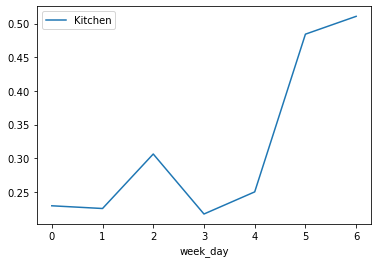

In [46]:
Kitchen_weekday.plot()

In [47]:
Laundry_weekday = df[["week_day", "Laundry"]].groupby(by="week_day").sum()
Laundry_weekday

,Laundry
week_day,
0,0.245995
1,0.383776
2,0.496033
3,0.201035
4,0.286776
5,0.417905
6,0.538517


<AxesSubplot:xlabel='week_day'>

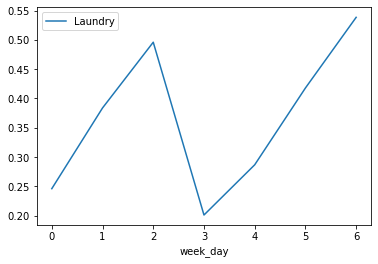

In [48]:
Laundry_weekday.plot()

In [49]:
Heater_weekday = df[["week_day", "Heater"]].groupby(by="week_day").sum()
Heater_weekday

,Heater
week_day,
0,1.768486
1,1.834978
2,1.812818
3,1.717255
4,1.926727
5,2.096790
6,1.668049


<AxesSubplot:xlabel='week_day'>

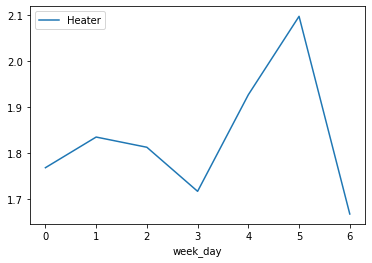

In [51]:
Heater_weekday.plot()

In [52]:
active_power_weekday = df[["week_day", "Active_power"]].groupby(by="week_day").sum()
active_power_weekday

,Active_power
week_day,
0,281790.024
1,303400.064
2,307539.010
3,276623.924
4,295667.644
5,345750.448
6,339842.078


In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df[[]]
clf_rf = RandomForestClassifier(random_state=0, criterion="gini")


clf_rf.fit(X_train,y_train)

# Dokonujemy predykcji dla danych testowych.
y_pred = clf_rf.predict(X_test)

# Obliczamy dokładność dla danych testowych
score = accuracy_score(y_test,y_pred)
print('Accuracy :',score)

# Wypisujemy czas który minął
print('Time taken :' , time.time()-t0)

In [ ]:
y = df.pop("RainTomorrow").values.ravel()
X = df

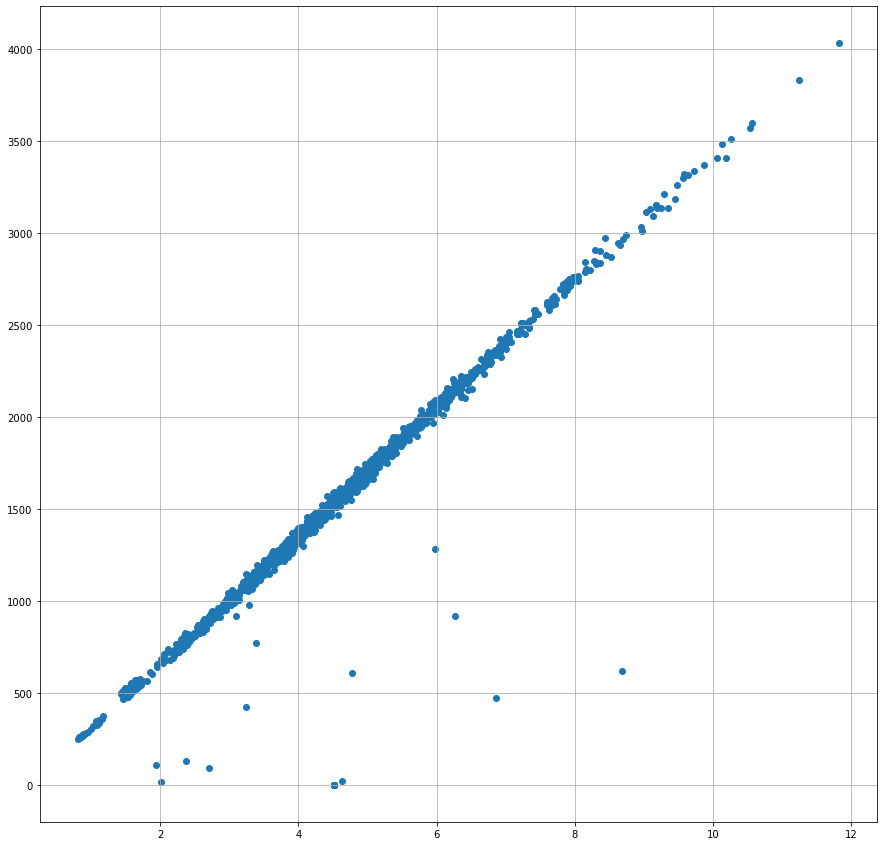

In [53]:
x = df["Intensity"].to_numpy()
y = df["Active_power"].to_numpy()
fig = plt.figure(figsize=(15,15))
plt.scatter(x,y,marker='o')
plt.grid()
plt.show()

In [54]:
model1=LinearRegression()

In [55]:
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

In [56]:
model1.fit(x,y)

LinearRegression()

In [57]:
model1.score(x,y)

0.9249951208827786

In [58]:
a = model1.coef_
a

array([[345.67069536]])

In [59]:
b = model1.intercept_
b

array([-46.88567437])

In [60]:
def linear_function(a,b,x):
    """
    predykcja liniowa
    """
    return a*x+b

In [61]:
y_pred = linear_function(a,b,x)
y_pred

array([[2689.77001689],
       [1236.94489017],
       [ 994.97540342],
       ...,
       [1167.09060382],
       [2106.30668901],
       [1417.07773031]])

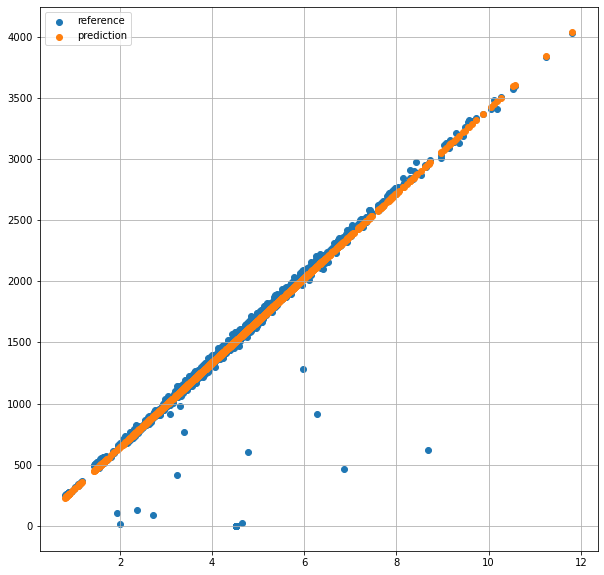

In [62]:
fig = plt.figure(figsize=(10,10))
plt.scatter(x,y,marker='o')
plt.scatter(x,y_pred)
plt.grid()
plt.legend(["reference", "prediction"])
plt.show()

In [63]:
yerr = y - y_pred
yerr

array([[59.23398311],
       [32.29110983],
       [19.07859658],
       ...,
       [37.33139618],
       [46.39331099],
       [59.35226969]])

In [ ]:
x_tmp = np.array([x[-1][0],40]).reshape(-1,1)
y_far_away = model1.predict(x_tmp)
y_far_away

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.scatter(x,y,marker='o')
plt.plot(x,y_pred)
plt.plot(x_tmp.reshape(-1), y_far_away.reshape(-1))
plt.grid()
plt.legend(["reference", "prediction", "far away"])
plt.show()

In [ ]:
# zamiana minut na godziny
df = df.resample("H", on="Date_time").agg({"Active_power": "sum", 
                                           "Reactive_power": "sum",
                                           "Voltage": "mean",
                                           "Intensity": "mean",
                                           "Kitchen": "sum",
                                           "Laundry": "sum",
                                           "Heater": "sum"}).reset_index()

In [ ]:
# matryca korelacji
correlation_matrix = np.round(df.corr(), 3)
correlation_matrix

In [ ]:
# heatmapa korelacji
sns.set(rc={'figure.figsize':(10,8)})
color_map = sns.diverging_palette(240, 10, n=10)
heatmap = sns.heatmap(correlation_matrix, cmap=color_map, annot=True, square=True);

In [ ]:
# opis statystyczny df
df.describe()

In [ ]:
# sprawdzenie nulli
df.info()

In [ ]:
# usuniecie nulli
df = df.dropna().reset_index(drop=True)

In [ ]:
# funkcja sprawdzająca szczytowy poziom mocy
def peak_check(row):
    if row["Active_power"] > 93.357 or row["Intensity"] > 6.546:
        return 1
    else:
        return 0

In [ ]:
# użycie funkcji na df
df["Peak"] = df.apply(lambda row: peak_check(row), axis=1)

In [ ]:
# sprawdzenie występowania wyników
df["Peak"].value_counts()

In [ ]:
# podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    df[["Kitchen", "Laundry", "Heater"]],
    df["Peak"],
    test_size=0.2,
    random_state=42)

In [ ]:
# standaryzacja
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# regresja logistyczna
model_scaled = LogisticRegression(random_state=42)
model_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = model_scaled.predict(X_test_scaled)

In [ ]:
# raport klasyfikacyjny
report_scaled = classification_report(y_test, y_pred_scaled)
print(report_scaled)